In [1]:
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shutil
import random
import string
import gzip
import json
def path_replace(path, old, new):
    return Path(str(path).replace(str(old), str(new)))
def crop_and_resize(img, target_size, mode="center"):
    """Crop to square and resize to target_size
    mode:
      center: center crop
      left: keep left or top most pixels
      right: keep right or bottom most pixels
      random: random crop
    """
    crop_size = min(img.size)
    width, height = img.size
    if width==target_size and height==target_size:
        return img
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    if mode == "center":
        img = img.crop((left, top, right, bottom))
    elif mode == "left":
        img = img.crop((0, 0, right-left, bottom-top))
    elif mode == "right":
        img = img.crop((width-right+left, height-bottom+top, width, height))
    elif mode == "random":
        left_r = random.randint(0, width-right+left)
        top_r = random.randint(0, height-bottom+top)
        img = img.crop((left_r, top_r, left_r+right-left, top_r+bottom-top))
    else:
        raise AssertionError("Wrong mode")
    img = img.resize((target_size, target_size),resample=Image.Resampling.LANCZOS)
    return img
def random_string(n):
    return ''.join(random.sample(string.ascii_letters + string.digits, n))

# ImageNet
1281167 train images, 50000 val images

In [2]:
FOLDER_IN = Path("/root/autodl-tmp/imagenet")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/imagenet")
SPLITS = ["train", "val"]
TARGET_SIZE = 224
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in tqdm(folder_in_split.glob("**/*.JPEG")):
        img = Image.open(image_in).convert("RGB")
        img = crop_and_resize(img, TARGET_SIZE, mode="random")
        image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
        image_out = path_replace(image_out, ".JPEG", ".jpg")
        if split=="val":
            image_out = image_out.parent.joinpath(image_out.name)
        else:
            image_out = image_out.parent.parent.joinpath(image_out.name)
        os.makedirs(image_out.parent, exist_ok=True)
        img.save(image_out)
        cnt+=1
print(cnt)

0it [00:00, ?it/s]

50000


1281167


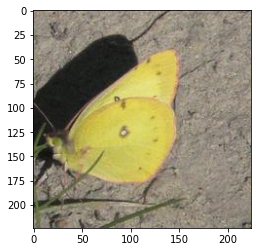

In [24]:
# check
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/imagenet/train")
path_check = random.choice(list(FOLDER_CHECK.glob("*.jpg")))
img = Image.open(path_check)
plt.imshow(img)
print(len(list(FOLDER_CHECK.glob("*.jpg"))))

# COCO

241690 train images, 5000 val images

In [3]:
FOLDER_IN = Path("/root/autodl-tmp/coco2017")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/coco")
SPLITS = ["train", "val"]
TARGET_SIZE = 224
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in tqdm(folder_in_split.glob("**/*.jpg")):
        img = Image.open(image_in).convert("RGB")
        img = crop_and_resize(img, TARGET_SIZE, mode="random")
        image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
        image_out = image_out.parent.joinpath(image_out.name)
        os.makedirs(image_out.parent, exist_ok=True)
        img.save(image_out)
        cnt+=1
print(cnt)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

246690


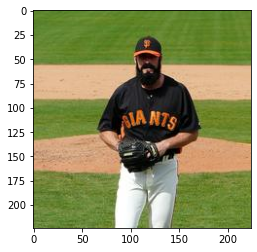

In [6]:
# check
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/coco/train")
path_check = random.choice(list(FOLDER_CHECK.glob("*.jpg")))
img = Image.open(path_check)
plt.imshow(img)

# VisualGenome
102671 train images, 5408 val images

In [11]:
# make train val splits
FOLDER_IN = Path("/root/autodl-tmp/visualgenome/VG_ALL")
FOLDER_TRAIN = Path("/root/autodl-tmp/visualgenome/VG_ALL/train")
FOLDER_VAL = Path("/root/autodl-tmp/visualgenome/VG_ALL/val")
all_images = list(FOLDER_IN.glob("*.jpg"))
N = len(all_images)
N_val = int(N*0.05)
val_images = random.sample(all_images, N_val)
for val_image in val_images:
    val_image_out = path_replace(val_image, FOLDER_IN, FOLDER_VAL)
    os.makedirs(val_image_out.parent, exist_ok=True)
    shutil.move(val_image, val_image_out)

train_images = list(FOLDER_IN.glob("*.jpg"))
for train_image in train_images:
    train_image_out = path_replace(train_image, FOLDER_IN, FOLDER_TRAIN)
    os.makedirs(train_image_out.parent, exist_ok=True)
    shutil.move(train_image, train_image_out)

In [ ]:
FOLDER_IN = Path("/root/autodl-tmp/visualgenome/VG_ALL")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/visualgenome")
SPLITS = ["train", "val"]
TARGET_SIZE = 224
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in tqdm(folder_in_split.glob("**/*.jpg")):
        try:
            img = Image.open(image_in).convert("RGB")
            img = crop_and_resize(img, TARGET_SIZE, mode="random")
            image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
            image_out = image_out.parent.joinpath(image_out.name)
            os.makedirs(image_out.parent, exist_ok=True)
            img.save(image_out)
            cnt+=1
        except UnidentifiedImageError:
            print("Invalid image", image_in)
print(cnt)

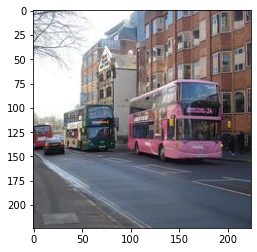

In [17]:
# check
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/visualgenome/train")
path_check = random.choice(list(FOLDER_CHECK.glob("*.jpg")))
img = Image.open(path_check)
plt.imshow(img)

# LAION

part of LAION High Resolution

3209027 train images, 46207 val images

In [15]:
# make train val splits

FOLDER_IN = Path("/root/autodl-tmp/laion/laion-high-resolution-output")
FOLDER_TRAIN = Path("/root/autodl-tmp/laion/laion-high-resolution-output/train")
FOLDER_VAL = Path("/root/autodl-tmp/laion/laion-high-resolution-output/val")
all_images = list(FOLDER_IN.glob("*.jpg"))
N = len(all_images)
N_val = int(N*0.05)
val_images = random.sample(all_images, N_val)
for val_image in val_images:
    val_image_out = path_replace(val_image, FOLDER_IN, FOLDER_VAL)
    val_image_out = path_replace(val_image_out, ".jpg", random_string(8)+".jpg")
    os.makedirs(val_image_out.parent, exist_ok=True)
    shutil.move(val_image, val_image_out)
    val_text_in = path_replace(val_image, ".jpg", ".txt")
    val_text_out = path_replace(val_image_out, ".jpg", ".txt")
    shutil.move(val_text_in, val_text_out)

train_images = list(FOLDER_IN.glob("*.jpg"))
for train_image in train_images:
    train_image_out = path_replace(train_image, FOLDER_IN, FOLDER_TRAIN)
    train_image_out = path_replace(train_image_out, ".jpg", random_string(8)+".jpg")
    os.makedirs(train_image_out.parent, exist_ok=True)
    shutil.move(train_image, train_image_out)
    train_text_in = path_replace(train_image, ".jpg", ".txt")
    train_text_out = path_replace(train_image_out, ".jpg", ".txt")
    shutil.move(train_text_in, train_text_out)

In [16]:
len(all_images)

990566

In [17]:
FOLDER_IN = Path("/root/autodl-tmp/laion/laion-high-resolution-output")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/laion")
FOLDER_TEXT_OUT = Path("/root/autodl-tmp/laion/laion-text")
SPLITS = ["train", "val"]
TARGET_SIZE = 224
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in folder_in_split.glob("**/*.jpg"):
        try:
            img = Image.open(image_in).convert("RGB")
            img = crop_and_resize(img, TARGET_SIZE, mode="random")
            image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
            image_out = image_out.parent.joinpath(image_out.name)
            os.makedirs(image_out.parent, exist_ok=True)
            img.save(image_out)

            text_in = path_replace(image_in, ".jpg", ".txt")
            text_out = path_replace(text_in, FOLDER_IN, FOLDER_TEXT_OUT)
            shutil.move(text_in, text_out)
            cnt+=1
        except UnidentifiedImageError:
            print("Invalid image", image_in)
print(cnt)

990566


3209027


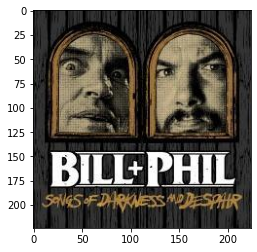

In [14]:
# check
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/laion/train")
all_images = list(FOLDER_CHECK.glob("*.jpg"))
path_check = random.choice(all_images)
img = Image.open(path_check)
plt.imshow(img)
print(len(all_images))

In [25]:
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/laion/val")
all_images = random.sample(list(FOLDER_CHECK.glob("*.jpg")),150000)
for image_in in all_images:
    image_out = path_replace(image_in, "/root/autodl-tmp/data/stage1/laion/val", "/root/autodl-tmp/data/stage1/laion/train")
    shutil.move(image_in, image_out)

# ConceptualCaption

6998886 train images, 368362 val images

In [4]:
FOLDER_IN = Path("/root/autodl-tmp/conceptual/cc12m")
FOLDER_TRAIN = Path("/root/autodl-tmp/conceptual/train")
FOLDER_VAL = Path("/root/autodl-tmp/conceptual/val")
all_images = list(FOLDER_IN.glob("*.jpg"))
N = len(all_images)
N_val = int(N*0.05)
val_images = random.sample(all_images, N_val)
for val_image in val_images:
    val_image_out = path_replace(val_image, FOLDER_IN, FOLDER_VAL)
    val_image_out = path_replace(val_image_out, ".jpg", ".jpg")
    os.makedirs(val_image_out.parent, exist_ok=True)
    shutil.move(val_image, val_image_out)
    val_text_in = path_replace(val_image, ".jpg", ".txt")
    val_text_out = path_replace(val_image_out, ".jpg", ".txt")
    shutil.move(val_text_in, val_text_out)

train_images = list(FOLDER_IN.glob("*.jpg"))
for train_image in train_images:
    train_image_out = path_replace(train_image, FOLDER_IN, FOLDER_TRAIN)
    train_image_out = path_replace(train_image_out, ".jpg", ".jpg")
    os.makedirs(train_image_out.parent, exist_ok=True)
    shutil.move(train_image, train_image_out)
    train_text_in = path_replace(train_image, ".jpg", ".txt")
    train_text_out = path_replace(train_image_out, ".jpg", ".txt")
    shutil.move(train_text_in, train_text_out)

In [7]:
FOLDER_IN = Path("/root/autodl-tmp/conceptual")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/cc12m")
FOLDER_TEXT_OUT = Path("/root/autodl-tmp/conceptual/cc12m-text")
SPLITS = ["train", "val"]
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in folder_in_split.glob("**/*.jpg"):
        try:
            image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
            image_out = image_out.parent.joinpath(image_out.name)
            os.makedirs(image_out.parent, exist_ok=True)
            shutil.move(image_in, image_out)

            text_in = path_replace(image_in, ".jpg", ".txt")
            text_out = path_replace(text_in, FOLDER_IN, FOLDER_TEXT_OUT)
            shutil.move(text_in, text_out)
            cnt+=1
        except FileNotFoundError:
            pass
print(cnt)

0


368362


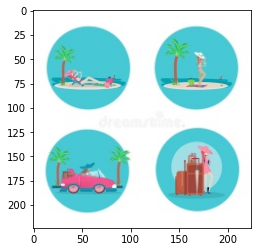

In [16]:
# check
FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/cc12m/val")
all_images = list(FOLDER_CHECK.glob("*.jpg"))
path_check = random.choice(all_images)
img = Image.open(path_check)
plt.imshow(img)
print(len(all_images))

# Scannet Depth

2331663 train images, 211938 val images

In [4]:
FOLDER_IN = Path("/root/autodl-tmp/data/stage1/scannet-depth")
FOLDER_OUT = Path("/root/autodl-tmp/data/stage1/scannet-depth")
SPLITS = ["train"]
TARGET_SIZE = 224
cnt = 0
for split in SPLITS:
    folder_in_split = FOLDER_IN / split
    folder_out_split = FOLDER_OUT / split
    for image_in in folder_in_split.glob("**/depth/*.png"):
        try:
            img = Image.open(image_in)
            img = crop_and_resize(img, TARGET_SIZE)
            image_out = path_replace(image_in, FOLDER_IN, FOLDER_OUT)
            image_out = path_replace(image_out, "/depth/", "/")
            os.makedirs(image_out.parent, exist_ok=True)
            img.save(image_out)
            os.remove(image_in)
            cnt+=1
        except UnidentifiedImageError:
            print("Invalid image", image_in)
print(cnt)

211938


2959.0
2331663


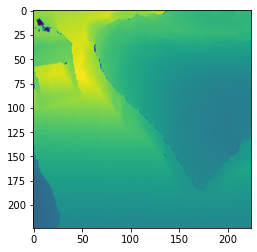

In [4]:
# check
import numpy as np

FOLDER_CHECK = Path("/root/autodl-tmp/data/stage1/depth-scannet/train")
all_images = list(FOLDER_CHECK.glob("*.png"))
path_check = random.choice(all_images)
img = Image.open(path_check)
img = np.array(img,dtype=float)
plt.imshow(img)
print(img.max())
print(len(all_images))

In [5]:
print(path_check)

/root/autodl-tmp/data/stage1/depth-scannet/train/scene0477_00_01679.png


# C4 text
10689518 train text, 45576 val text

In [4]:
# train split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_OUT = Path("/root/EvoEnc/data/stage1/text-c4/train")
os.makedirs(FOLDER_OUT,exist_ok=True)
START = 0
END =  30
files = sorted(list(FOLDER_IN.glob("c4-train*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            path = FOLDER_OUT / ("%08d.txt"%(cnt))
            with open(path, "w") as f:
                f.write(text)
            cnt += 1
print(cnt)

  0%|          | 0/30 [00:00<?, ?it/s]

TypeError: object of type 'int' has no len()

In [6]:
# validation split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_OUT = Path("/root/EvoEnc/data/stage1/text-c4/val")
os.makedirs(FOLDER_OUT,exist_ok=True)
START = 0
END =  1
files = sorted(list(FOLDER_IN.glob("c4-val*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            path = FOLDER_OUT / ("%08d.txt"%(cnt))
            with open(path, "w") as f:
                f.write(text)
            cnt += 1
print(cnt)

  0%|          | 0/1 [00:00<?, ?it/s]

45576


In [14]:
# check
FOLDER_OUT = Path("/root/autodl-tmp/stage1/text-c4/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(files[0])
with open(files[45], "r") as f:
    print(f.read())

/root/autodl-tmp/stage1/text-c4/val/00000000.txt
Marketers are employed in the public sector as well as the private sector. Most people think of marketing as a strictly private sector activity, but the reality is people with sales and marketing backgrounds are hired by government agencies in a number of capacities. Government agencies at the local, state and federal level all employ marketing professionals in areas including, but not limited to, public relations, property disposal, bond sales and purchasing. Almost all major government agencies have their own public-relations staff, and in many cases it is a stand-alone department with a public relations or media director and several support staff. Government agency PR departments are responsible for producing news releases, holding press conferences, and generally promoting activities of the agency, such as tourism or encouraging new businesses to move into the area. Government agencies are constantly buying supplies, equipment and ot

# C4 sub
10689519 train sub, 45576 val sub

In [8]:
from nltk.tokenize import sent_tokenize
sent_tokenize("hello, world! My name is Hzt")

['hello, world!', 'My name is Hzt']

In [11]:
from nltk.tokenize import sent_tokenize
# train split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_OUT = Path("/root/EvoEnc/data/stage1/sub-c4/train")
os.makedirs(FOLDER_OUT,exist_ok=True)
START = 30
END =  60
files = sorted(list(FOLDER_IN.glob("c4-train*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            path = FOLDER_OUT / ("%08d.txt"%(cnt))
            with open(path, "w") as f:
                f.write("\n".join(sent_tokenize(text)))
            cnt += 1
print(cnt)

  0%|          | 0/30 [00:00<?, ?it/s]

10689519


In [12]:
# validation split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_OUT = Path("/root/EvoEnc/data/stage1/sub-c4/val")
os.makedirs(FOLDER_OUT,exist_ok=True)
START = 1
END =  2
files = sorted(list(FOLDER_IN.glob("c4-val*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            path = FOLDER_OUT / ("%08d.txt"%(cnt))
            with open(path, "w") as f:
                f.write("\n".join(sent_tokenize(text)))
            cnt += 1
print(cnt)

  0%|          | 0/1 [00:00<?, ?it/s]

45576


In [10]:
# check
FOLDER_OUT = Path("/root/autodl-tmp/stage1/sub-c4/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(files[0])
with open(files[57], "r") as f:
    print(f.read())

/root/autodl-tmp/stage1/sub-c4/val/00000000.txt
Street waffles are a sensation that has yet to take the United States by storm.
These delicious goodies are popular in Europe, thanks to their light and fluffy texture and toppings that are downright addictive.
This delicious food has arrived in Cleveland thanks to one restaurant, and you truly need to sample their menu if you call this city home.
Prepare your taste buds, because this flavor sensation is going to knock your socks off.
At first glance, this building looks like any other on the campus of Case Western Reserve University.
Hidden under the Triangle Apartments at 11457 Mayfield Rd.
in Cleveland is a delicious destination with a flair for the dramatic.
Inside, Euro Wafel & Coffee Bar serves up some of the most delicious street waffles in all of Cleveland.
This destination opened in 2017 and has been delighting locals and college students ever since.
Belgian waffles, as you may know, are lighter and crispier than traditional waff

```
import wget
import os
URL_TEMPLATE = "https://huggingface.co/datasets/allenai/c4/resolve/main/en/c4-train.%05d-of-01024.json.gz?download=true"
FILE_TEMPLATE = "c4-train.%05d-of-01024.json.gz"
for i in range(1024):
    print(FILE_TEMPLATE%(i))
    while not os.path.exists(FILE_TEMPLATE%(i)):
        try:
            wget.download(URL_TEMPLATE%(i), out=FILE_TEMPLATE%(i))
        except:
            pass

import wget
URL_TEMPLATE = "https://huggingface.co/datasets/allenai/c4/resolve/main/en/c4-validation.%05d-of-00008.json.gz?download=true"
FILE_TEMPLATE = "c4-validation.%05d-of-00008.json.gz"
for i in range(8):
    wget.download(URL_TEMPLATE%(i), out=FILE_TEMPLATE%(i))
```